In [1]:
import numpy as np
import astra
from scipy.optimize import newton, root_scalar, minimize
import scipy.sparse as sp

In [2]:
import MGBlurr.blurring as blur
from MGTomo.utils import mylog, mydiv, myexp
import MGTomo.functions as fcts

from MGTomo.gridop import P, R
from MGTomo import gridop


import time
import numpy as np

import matplotlib.pyplot as plt 
from skimage import data
from skimage.transform import resize
import torch

import pylops

from MGTomo.optimize import orthant_bounds_optimized

In [3]:
np.int = np.int32
fine_dim = 63

max_levels = 1
maxIter = [1,2]
num_proj = fine_dim
angles = np.linspace(0, np.pi, num_proj, endpoint=False)  # Projection angles

det_count = 20

geometry = astra.create_proj_geom('parallel', 1.0, det_count, angles)
vol_geom = astra.create_vol_geom(fine_dim, fine_dim)
proj_id = astra.create_projector('line', geometry, vol_geom)
matrix_id = astra.projector.matrix(proj_id)

H = [sp.csr_matrix(astra.matrix.get(matrix_id))]

P_nonzero = []

for i in range(1, max_levels+1):
    coarse_dim = fine_dim//2
    num_proj = num_proj//2
    det_count = det_count//2
    angles = np.linspace(0, np.pi, num_proj, endpoint=False)  # Projection angles

    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))

    geometry = astra.create_proj_geom('parallel', 1.0, det_count, angles)
    vol_geom = astra.create_vol_geom(coarse_dim, coarse_dim)
    proj_id = astra.create_projector('line', geometry, vol_geom)
    matrix_id = astra.projector.matrix(proj_id)

    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))

    Hnew = astra.matrix.get(matrix_id)
    H.append(sp.csr_matrix(Hnew))

    fine_dim = coarse_dim

In [4]:
H[1].shape

(310, 961)

In [5]:
def objective(x, H):
    X = np.diag(x)
    FIM = H @ X @ H.T
    #eigenvalues = np.linalg.eigvals(FIM)
    #is_psd = np.all(eigenvalues >= 0)
    #print(is_psd)
    #print(np.linalg.matrix_rank(FIM))
    sgn, logdet = np.linalg.slogdet(FIM)
    #return - log_padded
    return - logdet

In [6]:
def derivative_obj(x, H):
    X = sp.diags(x)
    HXHT = (H @ X @ H.T).tocsc()

    # #HXHT_inv = sp.linalg.splu(HXHT).solve(sp.eye(HXHT.shape[0]).tocsc())

    # Perform LU decomposition
    lu = sp.linalg.splu(HXHT)  

    n = HXHT.shape[0]
    C_diag = np.zeros(H.shape[1])  # Store diagonal values only

    for i in range(H.shape[1]):
        #print(i)
        ei = np.zeros(H.shape[1])
        ei[i] = 1  # Unit vector for the i-th column
        HXHT_inv_Hi = lu.solve(H @ ei)  # Solve for H[:, i]
        C_diag[i] = (H[:, i].T @ HXHT_inv_Hi).item()  # Extract diagonal entry

    return - C_diag

def deriv_geom(x):
    return -1/x

def newton_equation(theta, c, eq_constraint):
    return np.sum(1 / (c + theta)) - eq_constraint

def stable_netwon_equation(c, theta, eq_constraint):
    safe_c_theta = np.clip(np.abs(c + theta), 1e-10, None)  # Avoid log(0)
    return np.sum(np.exp(-np.log(safe_c_theta))) - eq_constraint  # Uses log instead of division

def newton_derivative(theta, c, eq_constraint):
    max_val=np.ones_like(c)*1e-10
    return -np.sum(1 / np.maximum((c + theta) ** 2, max_val))

def stable_netwon_derivative(c, theta, eq_constraint):
    safe_c_theta = np.clip(np.abs(c + theta), 1e-10, None)  # Avoid log(0)
    return -np.sum(np.exp(-2 * np.log(safe_c_theta)))  # Uses log instead of division


In [7]:
x = np.ones(H[0].shape[1]) / H[0].shape[1]
x.min()

0.0002519526329050139

In [8]:
np.linalg.matrix_rank(H[1].toarray())

310

In [9]:
fh = lambda x: objective(x, H[0])

In [10]:
def simplex_projection(x):
    # First, ensure the sum of the components equals 1
    x = np.maximum(x, 1e-4)  # Set a small lower bound to ensure positivity

    # Sort the elements of x in descending order
    sorted_x = np.sort(x)[::-1]
    cumulative_sum = np.cumsum(sorted_x)
    
    # Find the largest rho such that sorted_x[rho] > (cumulative_sum[rho] - 1) / (rho + 1)
    rho = np.max(np.where(sorted_x > (cumulative_sum - 1) / np.arange(1, len(x) + 1)))
    
    # Compute the threshold (theta)
    theta = (cumulative_sum[rho] - 1) / (rho + 1)
    
    # Subtract theta from the sorted components and ensure strictly positive values
    projected_x = np.maximum(x - theta, 1e-4)  # Ensure strict positivity by bounding below
    
    return projected_x


In [11]:
def armijo_linesearch(f, x: torch.tensor, d: torch.tensor, a=.5, r = 0.5, c = 1e-3):
    fx = f(x)

    #fx.backward(retain_graph=True)
    dfx = derivative_obj(x, H[0])
    dgk = np.sum(dfx * d)
    
    #assert dgk <= 0, 'd needs to be a descent direction (dgk = %.5e)' % dgk
    
    if dgk == 0.:
        return x, 0.
    
    while True:
        x_new = x + a * d
        
        f_new = f(x_new)
        
        if f_new <= fx + a * c * dgk:
            #x_new = simplex_projection(x_new)
            break
        
        a *= r
        if a <= 1e-7:
            print('Armijo step too small, a = 0')
            return x, 0.
    
    return x_new, a

In [12]:
def simplex_armijo(f,x, d, a = 1., c = 1e-3):
    fx = f(x)

    #fx.backward(retain_graph=True)
    dfx = derivative_obj(x, H[0])
    dgk = np.sum(dfx * d)
    
    assert dgk <= 0, 'd needs to be a descent direction (dgk = %.5e)' % dgk
    
    if dgk == 0.:
        return x
    
    x_new = x + a * d
        
    f_new = f(x_new)
        
    if f_new <= fx + a * c * dgk:
        print('updated z')
        return x_new
    else:
        return x

In [13]:
x = np.ones(H[0].shape[1]) / 100
y = np.ones(H[1].shape[1]) / 100

In [14]:
np.sum(R((torch.Tensor(x.reshape(63, 63)))).numpy().flatten()*y)

1.5375999656319617

In [15]:
np.sum(P((torch.Tensor(y.reshape(31, 31)))).numpy().flatten()*x)

1.5375999656319619

In [16]:
def MLO(y, last_pts: list, l=0, kappa = 0.45, eps = 0.001, theta = 30):
    y_tensor = torch.Tensor(y.reshape(63, 63))
    x_tensor = R(y_tensor)
    x = x_tensor.numpy().flatten()
    y0 = y
    #fhy0 = objective(y, H[l])
    dfhy0 = derivative_obj(y, H[l])
    
    if True:
        print(l, ' : coarse correction activated')
        last_pts[l] = y
    
        x0 = x
        fH = lambda x: objective(x, H[l+1])
        #fHx0 = fH(x0)
        dfHx0 = derivative_obj(x, H[l+1])

        kappa = R(torch.Tensor(dfhy0.reshape(63, 63))).numpy().flatten() - dfHx0
        S = np.sum(x0)
        print('S: ', S)

        psi = lambda x: fH(x) + np.sum(kappa * x)
        lH = orthant_bounds_optimized(y_tensor, x_tensor, 1, torch.zeros_like(y_tensor), P_nonzero[l]).numpy().flatten()
        #print('lHmin: ', lH.min())

        dfHx = derivative_obj(x,H[l+1])

        for i in range(maxIter[l+1]):
            c = dfHx + kappa - deriv_geom(x)
            upper_bound = np.max(1/lH - c)
            print(upper_bound)
            #print(c.min())
            #print(c.max())
            #theta = newton(stable_netwon_equation, theta, fprime=stable_netwon_derivative, args=(c,S), maxiter=100)
            res = root_scalar(stable_netwon_equation, bracket=[-np.min(c), upper_bound], args=(c, S), x0 =  theta, fprime=stable_netwon_derivative, method="bisect")
            theta = res.root
            #print('theta:', theta)
            x = 1/(c+theta)
            print('xmin - lH: ', np.max(x - lH), np.min(x-lH))
            print('xsum: ', np.sum(x))
            dfHx = derivative_obj(x,H[l+1])
            print('FH: ', psi(x))

        #print(np.linalg.norm(derivative_obj(x, H[l+1]) + kappa))
        #print('descent_direction' , np.sum(dfHx0 * (x-x0)))

        # if l < max_levels-1:
        #     x, last_pts = MLO(psi, x,lH, uH, last_pts, l+1)

        d = P(torch.Tensor((x-x0).reshape(31, 31))).numpy().flatten()

        print('descent_direction', np.sum(dfhy0*d))

        z = simplex_armijo(fh, y0, d)
        print('zmin', z.min())
        print('z sum:', np.sum(z))
        y = z
    else: 
        print(l, ' : coarse correction not activated')
    
    theta = 100
    for i in range(maxIter[l]):
        c = derivative_obj(y, H[l]) - deriv_geom(y)
        res = root_scalar(stable_netwon_equation, bracket=[-np.min(c), 1e5], args=(c, 1), x0 =  theta, fprime=stable_netwon_derivative, method="bisect")
        theta = res.root
        y = 1/(c+theta)
    return y, last_pts

In [17]:
last_pts = [None]*(max_levels+1)
x = np.ones(H[0].shape[1]) / 100
print(fh(x))
#theta = 100

iteration_times_ML = []
iteration_times_ML.append(0)

for i in range(2):
    
    iteration_start_time_ML = time.time()
    x, ylast = MLO(x,last_pts)
    iteration_end_time_ML = time.time()
    
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML
    fx = fh(x)
    print(f"Iteration {i}: {fx} - Time: {iteration_time_ML:.6f} seconds")

overall_time_ML = sum(iteration_times_ML)

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

1652.3873137209164
0  : coarse correction activated
S:  153.75998
1154.039958000183
xmin - lH:  142.43561155848207 -0.14893209924794415
xsum:  153.759979275125
FH:  -174835.7972647542
1155.7424831874744
xmin - lH:  142.7242770017183 -0.149430917083214
xsum:  153.7599792611442
FH:  -175087.82027697127
descent_direction -98494.04446562265
updated z
zmin -0.6277236843109131
z sum: 39.68976557493056
Iteration 0: 6290.736974221414 - Time: 21.011258 seconds


KeyboardInterrupt: 

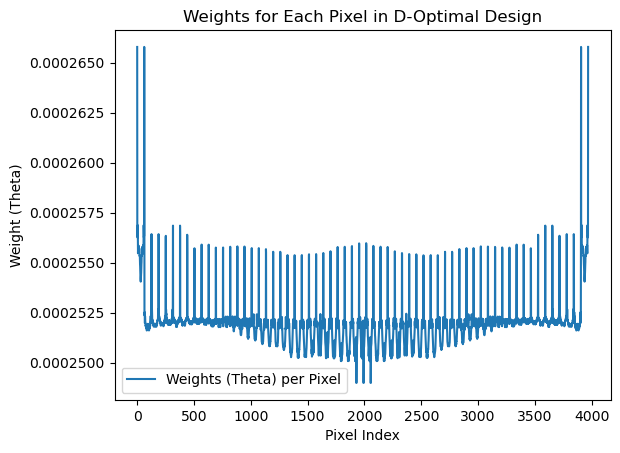

In [27]:
plt.plot(x, label="Weights (Theta) per Pixel")
plt.xlabel("Pixel Index")
plt.ylabel("Weight (Theta)")
plt.title("Weights for Each Pixel in D-Optimal Design")
plt.legend()
plt.show()

In [18]:
x.sum()

0.9999999999999971

In [19]:
solution_vec = []

x = np.random.random(H[0].shape[1])
theta = 100

solution_vec.append(x)

print('-1', fh(x))

for i in range(50):
    c = derivative_obj(x, H[0]) - deriv_geom(x)
    theta = newton(newton_equation, theta, fprime=newton_derivative, args=(c,1))
    x = 1/(c+theta)
    solution_vec.append(x)
    # print(sum(x))   
    print(i, fh(x))
    # print(np.linalg.norm(derivative_obj(x))) 

-1 -3175.147157144437
0 6290.3914363743015
1 6194.7021216325875
2 6147.723361575382
3 6124.215894275608
4 6110.701382002867
5 6102.0974111405285
6 6096.232020715092
7 6092.025624842941
8 6088.88526091531
9 6086.462758806007
10 6084.54298642081
11 6082.987185665651
12 6081.702438716291
13 6080.624439279006
14 6079.707381528949
15 6078.917810831557
16 6078.23075835163
17 6077.6272359150025
18 6077.09256641141
19 6076.615242554576
20 6076.186128848341
21 6075.797892027994
22 6075.4445870377
23 6075.1213510824955
24 6074.824174205547
25 6074.549724996764
26 6074.295216647321
27 6074.058302945557
28 6073.8369967687895
29 6073.629605660241
30 6073.434680507005
31 6073.25097435008
32 6073.077409092904
33 6072.913048413565
34 6072.757075584227
35 6072.608775200369
36 6072.4675180460645
37 6072.33274849249
38 6072.203973955732
39 6072.080756040233
40 6071.962703069669
41 6071.849463767476
42 6071.740721894645
43 6071.636191688676
44 6071.535613976116
45 6071.438752853545
46 6071.345392849745
47

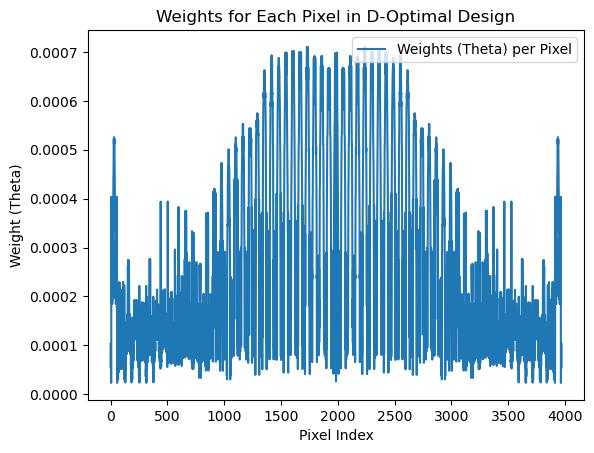

In [25]:
plt.plot(x, label="Weights (Theta) per Pixel")
plt.xlabel("Pixel Index")
plt.ylabel("Weight (Theta)")
plt.title("Weights for Each Pixel in D-Optimal Design")
plt.legend()
plt.show()

In [27]:
X = np.diag(x)
FIM = H[0] @ X @ H[0].T
W = np.diag(FIM)

In [ ]:
# Solve least squares problem: Hx = y
x_ls, residuals, rank, s = np.linalg.lstsq(H[0], y, rcond=None)

# Reshape x back into an image (assuming square)
nx, ny = 128, 128  # Adjust based on your volume geometry
x_ls_image = x_ls.reshape((nx, ny))
